# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import linear_model

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [3]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['dummy5_full.csv','dummy3_full.csv','dummy2_full.csv','dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        d[idx].get_HRV()
        d[idx].get_PA()
        d[idx].get_sleep(q_sleep=0.4, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        d[idx].get_windows()
        d[idx].get_SRI(q_sleep=0.4)
        #d[idx].get_cosinor()
        d[idx].get_SSA()
        d[idx].get_nonlinear()
        #d[idx].Crespo(zeta=15, zeta_r=50, zeta_a=2,t=.50, alpha='7h', beta='1h',
        #              estimate_zeta=False, seq_length_max=100, verbose=False)
        d[idx].get_daily_stats()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
None
None
None
None


In [88]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

#Create populatoin-level stats on daily basis
e = defaultdict(dict)
d_pop = pd.DataFrame()
for idx in d.keys():
    d[idx].get_daily_stats()
    e[idx] = d[idx].daily_stats.copy()
    e[idx]['sub'] = idx
    d_pop = pd.concat([d_pop,e[idx]],axis=0)

new = d_pop.copy()
#Transform to timedelta columns
new['sleep_onset_t'] = new['sleep_onset']-new.index
new['sleep_offset_t'] = new['sleep_offset']-new.index #timedelta64[ns]
new['ENMO_SSA_phi_t'] = new['ENMO_SSA_phi']-new.index
new['mean_hr_SSA_phi_t'] = new['mean_hr_SSA_phi']-new.index

d_pop_t = new.copy()

print(d_pop_t.head())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                    ENMO  MET_Sed    MET_MVPA   MET_VigPA  min_MVPA  \
ts                                                                    
2005-07-08  22601.284114      256  546.044923   68.659900       183   
2005-07-09  15972.616558      587  150.525186    0.000000        55   
2005-07-10  17738.668182      761  155.128692    0.000000        49   
2005-07-11  26352.086395      421  530.051671   45.028176       185   
2005-07-12   5126.145180      833   13.807771    0.000000         6   
2005-07-13  17042.890592      688  213.146694   51.363569        64   
2005-07-14   4416.300446      286   31.570517    0.000000        14   
2005-06-17   9110.906005      286   22.714160    0.000000         9   
2005-06-18  24773.034323      499  374.578986  146.561968       103   
2005-06-19  15692.117230      506  192.523698   76.017263        47   
2005-06-20  24787.954500      190  121.150347    0.000000   

[26 rows x 35 columns]


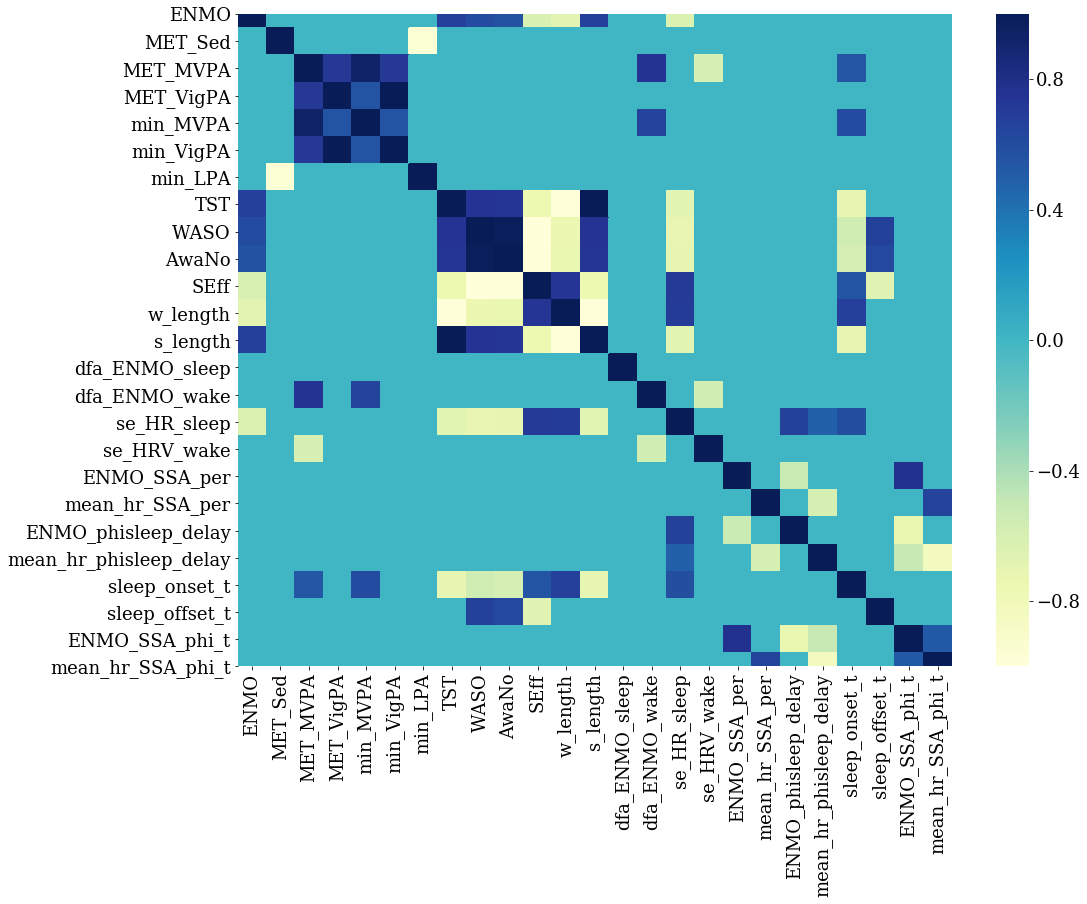

In [90]:
#Get corr for PA-SLeep
from population_stats import get_corr

trans_col = ['sleep_onset','sleep_offset','ENMO_SSA_phi','mean_hr_SSA_phi']
d_pop_sel = d_pop_t.drop(['weekday','sub','dfa_HR_sleep','dfa_HR_wake', 'dfa_HRV_wake','dfa_HRV_sleep',
                        'se_ENMO_sleep','se_ENMO_wake','se_HR_wake','se_HRV_sleep']+trans_col,axis=1)


f1 = get_corr(d_pop_sel)

fig1 = f1.get_figure()    
fig1.savefig('corr_pas.png')

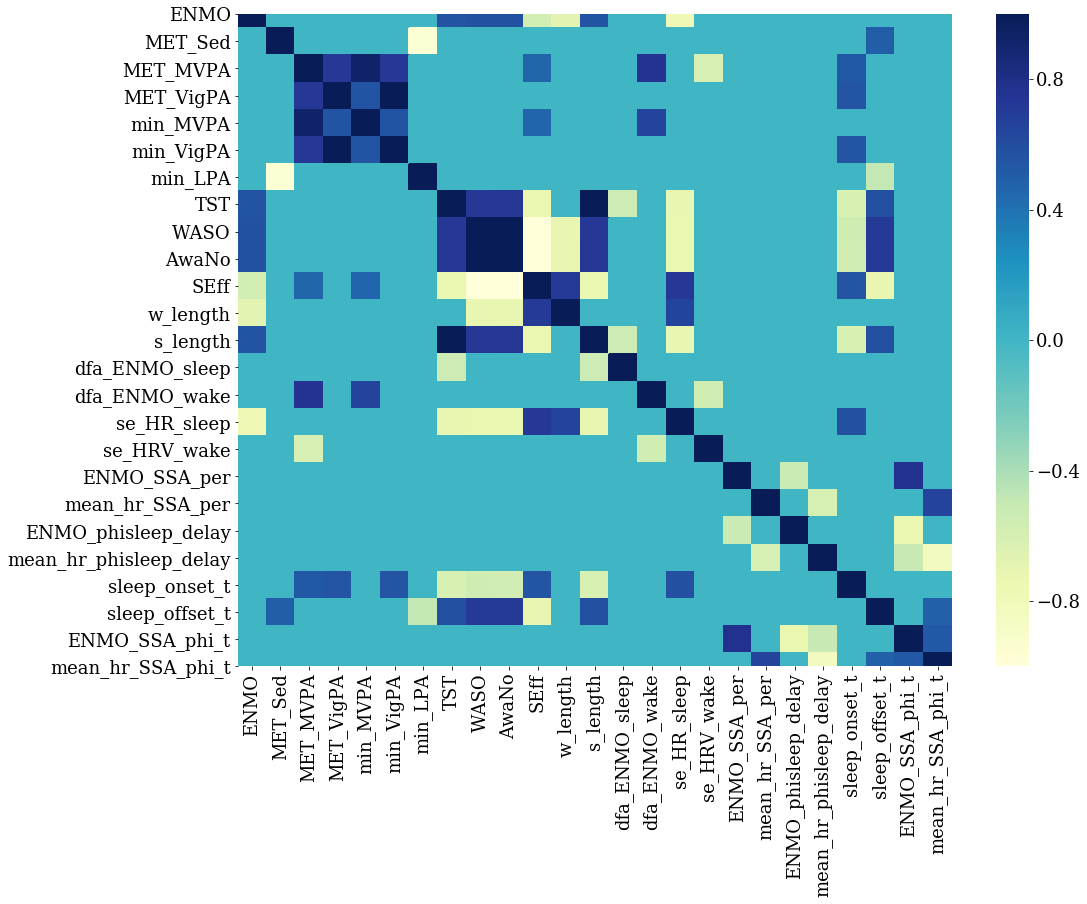

In [92]:
#Get corr for Sleep-PA(+1)
df = d_pop_t.copy()

pa_cols = ['ENMO',  'MET_Sed' ,  'MET_MVPA', 'MET_VigPA' , 'min_MVPA' , 'min_VigPA',  'min_LPA']
pa_cols_other = ['w_length', 'dfa_ENMO_wake','se_HRV_wake','ENMO_SSA_phi', 'mean_hr_SSA_phi',
        'ENMO_SSA_phi_t', 'mean_hr_SSA_phi_t','ENMO_SSA_per', 'mean_hr_SSA_per', 'ENMO_phisleep_delay',
       'mean_hr_phisleep_delay']

df_2 = df[pa_cols+pa_cols_other].groupby(df['sub']).shift(-1)
df_3 = df.copy()
df_3[pa_cols+pa_cols_other] = df_2[pa_cols+pa_cols_other]
d_pop_spa = df_3

d_pop_sel_spa = d_pop_spa.drop(['weekday','sub','dfa_HR_sleep','dfa_HR_wake', 'dfa_HRV_wake','dfa_HRV_sleep',
                        'se_ENMO_sleep','se_ENMO_wake','se_HR_wake','se_HRV_sleep']+trans_col,axis=1)


f2 = get_corr(d_pop_sel_spa)

fig2 = f2.get_figure()    
fig2.savefig('corr_spa.png')

In [94]:
#Write to file

d_pop_sel.to_csv('corr_pas_data.csv')

d_pop_sel_spa.to_csv('corr_spa_data.csv')